In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit, float64
from numba.types import UniTuple
from time import time
from scipy import ndimage

from scipy.interpolate import RectBivariateSpline

from ipywidgets import FloatProgress
from IPython.display import display

%load_ext line_profiler

from numerical_integrators.single_step import euler, rk2, rk3, rk4

from numerical_integrators.adaptive_step import rkdp54

import multiprocessing as mp

In [13]:
def grid_of_particles(Nx, Ny = None, wx = 2, wy = 1):
    if Ny == None:
        Ny = np.round(Nx*wy/wx).astype(int)
        
    dx = wx / Nx
    dy = wy / Ny
    
    x0 = (np.arange(Nx) + 1/2) * dx
    y0 = (np.arange(Ny) + 1/2) * dy
    
    y, x = np.meshgrid(y0, x0)
    
    return np.array([x,y])


# Implementation of Eq. (1) in the exam set
@jit(nopython = True)
def doublegyre(t, x, A, e, w):
    a = e * np.sin(w*t)
    b = 1 - 2*e*np.sin(w*t)
    f = a*x[0,:]**2 + b*x[0,:]
    v = np.empty(x.shape)
    v[0,:] = -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*x[1,:])                    # x component of velocity
    v[1,:] =  np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*x[1,:]) * (2*a*x[0,:] + b) # y component of velocity
    return v

# Wrapper function to pass to integrator
# X0 is a two-component vector [x, y]
@jit(nopython = True)
def f(t, x):
    # Parameters of the velocity field
    A = 0.1         # A
    e = 0.1         # epsilon
    w = 2*np.pi/10  # omega
    return doublegyre(t, x, A, e, w)

In [14]:
def endpoints(t_min, t_max, pos, h, integrator, deriv):
    if (integrator.__name__ == 'euler' or integrator.__name__ == 'rk2' or integrator.__name__ == 'rk3' or integrator.__name__ == 'rk4'):
        return _endpoints_fixed(t_min, t_max, pos, h, integrator, deriv)
    else:
        return __endpoints_adaptive(t_min, t_max, pos, h, integrator, deriv)
    
def _endpoints_fixed(t_min, t_max, pos, h, integrator, deriv):
    t = t_min
    for j in range(np.ceil((t_max - t_min)/h).astype(int)):
        t, pos, h = integrator(t, pos, h, deriv)
    return pos

def __endpoints_fixed(t_min, t_max, pos, h, integrator, deriv, n_proc = 4):
    
    part = np.floor(np.size(pos,1) / n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    
    processlist = [mp.Process(target = __endpoints_fixed_slice, 
                             args = (t_min, t_max, 
                                    pos[:, j*part:-1 if j + 1 == n_proc else (j+1)*part], 
                                    h, integrator, deriv, queuelist[j])) for j in range(n_proc)]

    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, j*part:-1 if j+1 == n_proc else (j+1)*part] = queue.get()
    
    for process in processlist:
        process.join()
    
    return pos
    
def __endpoints_fixed_slice(t_min, t_max, pos, h, integrator, deriv, q):
    t = t_min
    for j in range(np.ceil((t_max - t_min)/h).astype(int)):
        t, pos, h = integrator(t, pos, h, deriv)
    q.put(pos)

def __endpoints_adaptive(t_min, t_max, pos, h, integrator, deriv, n_proc = 4):
    part = np.floor(np.size(pos,1) / n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    
    processlist = [mp.Process(target = __endpoints_adaptive_slice, 
                             args = (t_min, t_max, 
                                    pos[:, j*part:-1 if j + 1 == n_proc else (j+1)*part], 
                                    h, integrator, deriv, queuelist[j])) for j in range(n_proc)]

    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, j*part:-1 if j+1 == n_proc else (j+1)*part] = queue.get()
    
    for process in processlist:
        process.join()
    
    return pos

def __endpoints_adaptive_slice(t_min, t_max, pos, h, integrator, deriv, q):
    t = np.ones(np.shape(pos[0]))*t_min
    h = np.ones(np.shape(t))*h
    
    while np.any(np.less(t, t_max)):
        h = np.minimum(h, t_max - t)
        t, pos, h = integrator(t, pos, h, deriv)
        
    q.put(pos)

# Step 0: Check that it works

In [16]:
Nx = 200
pos_init = grid_of_particles(Nx)

# Transport parameters:
t_min = 0.
t_max = 20.
h = 0.1

integrator = rk4

# Loop over grid and update all positions
# With timing
tic = time()
pos_fin = endpoints(t_min, t_max, pos_init, h, integrator, f)
toc = time()

print('Transport took {} seconds'.format(toc - tic))

Transport took 2.7275373935699463 seconds


(0, 1)

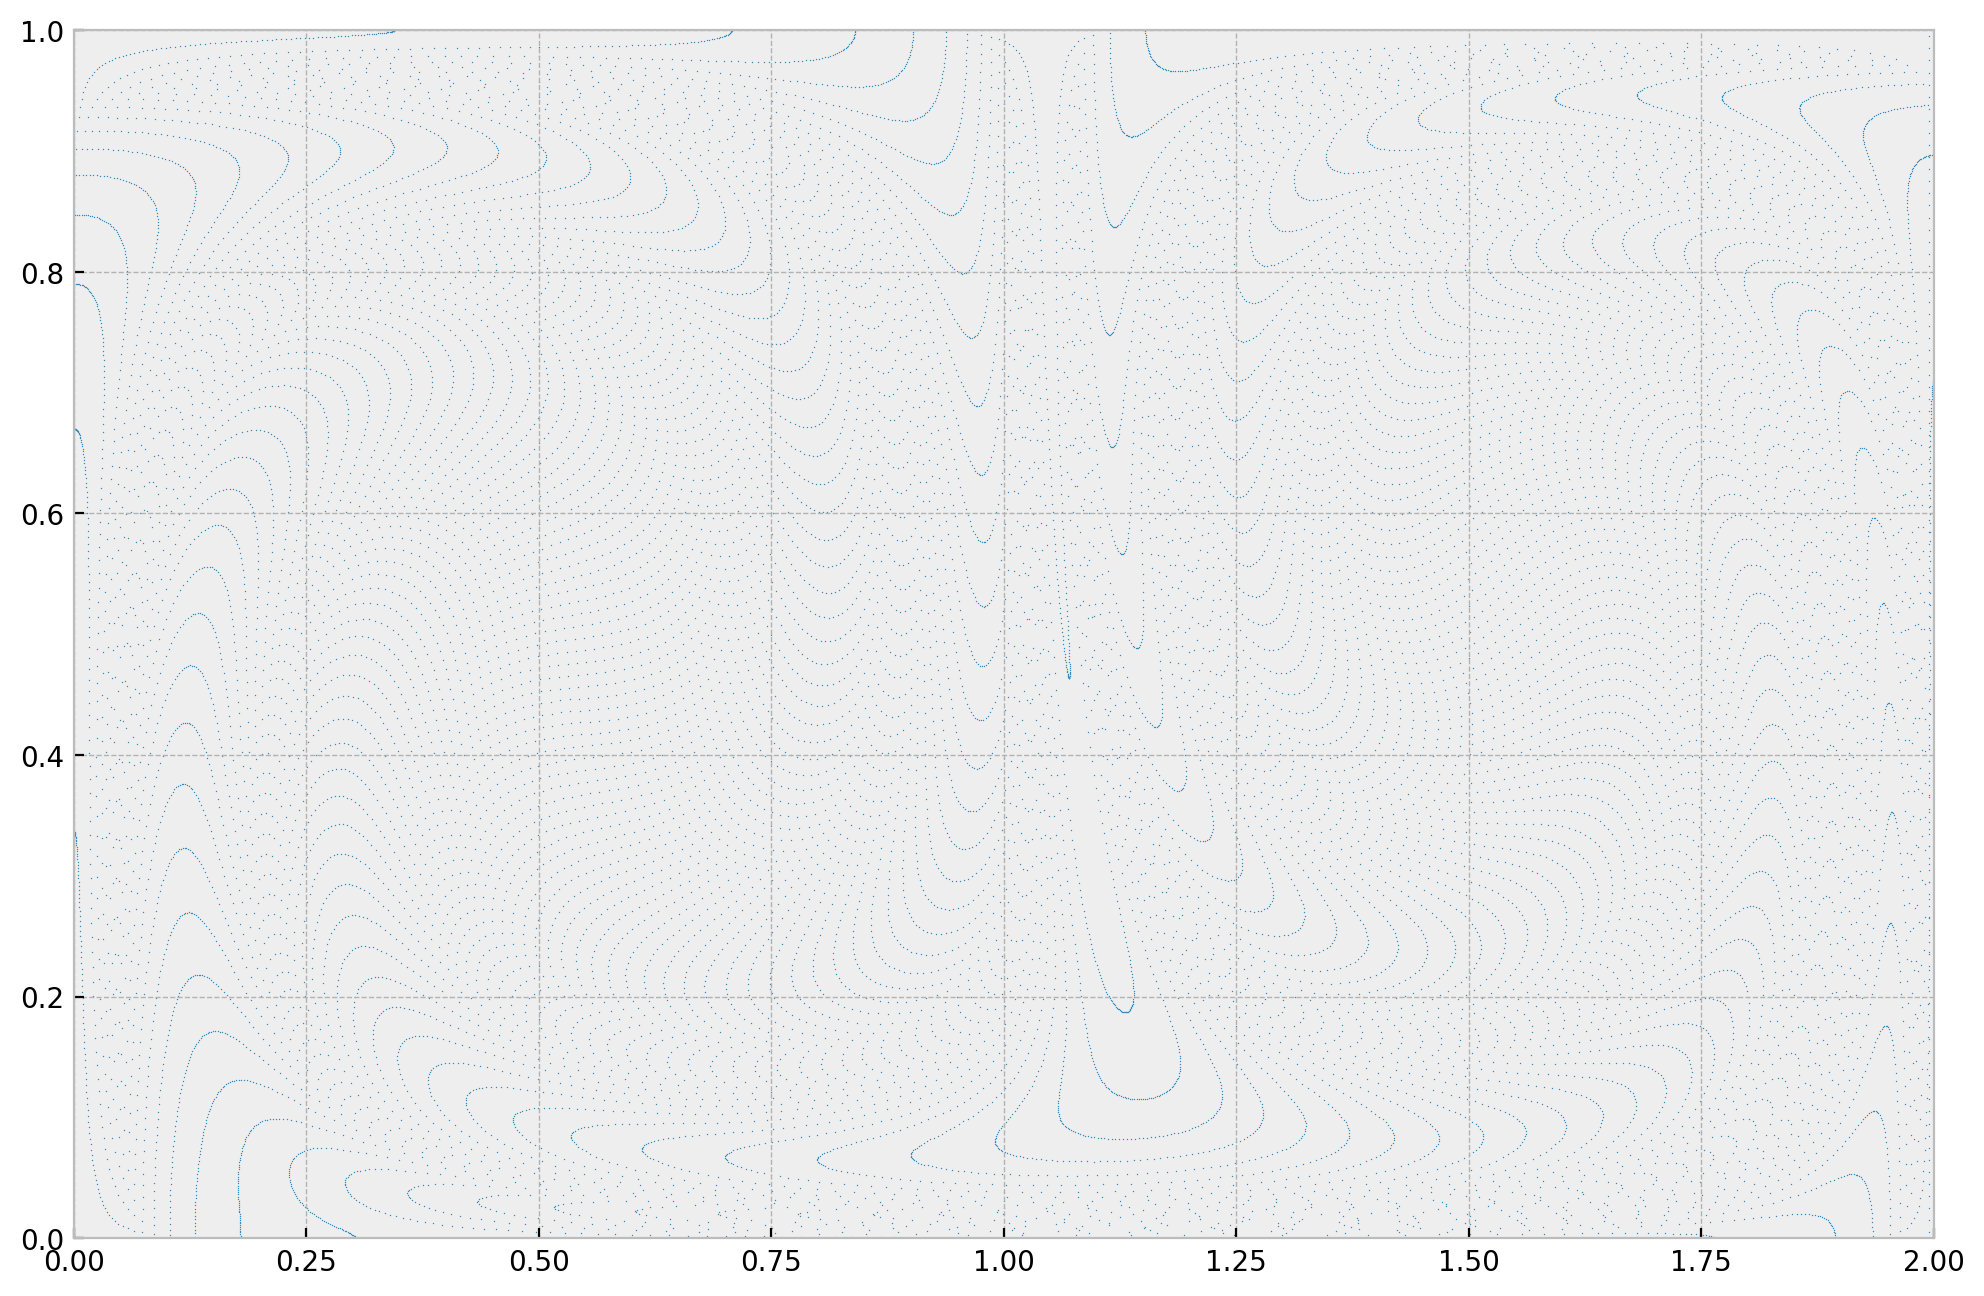

In [22]:
# Scatter plot with all grid points:
plt.figure(figsize = (12, 8), dpi = 200)
plt.scatter(pos_fin[0], pos_fin[1], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

# Step 2: Advect a large number of particles

### Including auxiliary grid

In [17]:
# Particle count in x-direction
Nx = 1000
# Particle count in y-direction
Ny = 500

# ----
#      New transport parameters
# ----
t_min = 0.
t_max = 20.
h = 0.1

# ----
#      Integrator
# ----
integrator = rk4

# ----
#      Main grid:
# ----

pos_init = grid_of_particles(Nx, Ny)

# Grid parameters, main grid:
dx = pos_init[0, -1, 0] - pos_init[0, -2, 0]
dy = pos_init[1, 0, -1] - pos_init[1, 0, -2]

d = np.minimum(1e-5, dx*1e-2)

tic = time()

# ----
#      Get trajectory endpoints
# ----

arr = np.array([pos_init, pos_init + np.array([d,0]).reshape(2,1,1), 
                        pos_init + np.array([0,d]).reshape(2,1,1), 
                        pos_init + np.array([-d,0]).reshape(2,1,1), 
                        pos_init + np.array([0,-d]).reshape(2,1,1)])

n_proc = 4
part = np.floor(np.size(arr,2)/n_proc).astype(int)

queuelist = [mp.Queue() for j in range(n_proc)]
processlist = [mp.Process(target = endpoints, 
                         args = (t_min, t_max, 
                                arr[:,:,j*part:np.size(arr,2) if j + 1 == n_proc else (j+1)*part], 
                                h, integrator, f)) for j in range(n_proc)]

for process in processlist:
    process.start()
for j, queue in enumerate(queuelist):
    arr[:,:,j*part:np.size(arr,2) if j + 1 == n_proc else (j+1)*part] = queue.get()
for process in processlist:
    process.join()
    
toc = time()

    

#pos_fin = endpoints(t_min, t_max, pos_init, h, integrator, f)

#above_fin = endpoints(t_min, t_max, pos_init + np.array([0,d]).reshape(2,1,1), h, integrator, f)
#beneath_fin = endpoints(t_min, t_max, pos_init + np.array([0,-d]).reshape(2,1,1), h, integrator, f)

#right_fin = endpoints(t_min, t_max, pos_init + np.array([d,0]).reshape(2,1,1), h, integrator, f)
#left_fin = endpoints(t_min, t_max, pos_init + np.array([-d,0]).reshape(2,1,1), h, integrator, f)

#toc = time()

print('Transport took %.3f seconds' % (toc - tic))


KeyboardInterrupt: 

In [16]:
import os
os.getcwd()

'/home/arne/Documents/physicsproject/calculation_scripts/time-to-find-lcs-god-damnit'

In [11]:
np.shape(arr)

(5, 2, 1000, 500)

In [7]:
arr.ndim

4

In [14]:
np.size(arr,0)

5